<a href="https://colab.research.google.com/github/mrtnoshad/SampleCodes-/blob/master/Unsupervised_Classification_using_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
a=[0,1,2,3]
print(a[1:-1])

[1, 2]


https://towardsdatascience.com/text-classification-with-no-model-training-935fe0e42180 

In [2]:
## for data
import json
import pandas as pd
import numpy as np
from sklearn import metrics, manifold
## for processing
import re
import nltk
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for w2v
import gensim
import gensim.downloader as gensim_api
## for bert
! pip install transformers
import transformers

     |████████████████████████████████| 2.3MB 8.6MB/s 
     |████████████████████████████████| 3.3MB 50.8MB/s 
     |████████████████████████████████| 901kB 43.8MB/s 


In [6]:
# get the data
# dataset courtesy Rishabh Misra & Kaggle
# Link: https://www.kaggle.com/rmisra/news-category-dataset
# data is also availabl here: https://www.kaggle.com/rmisra/news-category-dataset?select=News_Category_Dataset_v2.json 
! git clone https://github.com/nomadotto/News_Classifier.git
% cd News_Classifier

Cloning into 'News_Classifier'...
remote: Enumerating objects: 25, done.
remote: Total 25 (delta 0), reused 0 (delta 0), pack-reused 25
Unpacking objects: 100% (25/25), done.
/content/News_Classifier


In [7]:
lst_dics = []
with open('News_Category_Dataset_v2.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        lst_dics.append( json.loads(dic) )
## print the first one
lst_dics[0]

{'authors': 'Melissa Jeltsen',
 'category': 'CRIME',
 'date': '2018-05-26',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.'}

In [46]:
## create dtf
dtf = pd.DataFrame(lst_dics)
## filter categories
dtf = dtf[ dtf["category"].isin(['ENTERTAINMENT','POLITICS','TECH'])        ][["category","headline"]]
## rename columns
dtf = dtf.rename(columns={"category":"y", "headline":"text"})
## print 5 random rows
dtf.sample(5)

,y,text
31046,POLITICS,"Trump And Master Salesmanship Lose, Facts And ..."
112090,ENTERTAINMENT,Exclusive New Lady Antebellum Video
35977,POLITICS,There Have Been No Fatal Terror Attacks In The...
58609,TECH,How A Digital Divide Leaves Parts Of Rural Ame...
25941,POLITICS,Trump Denies Mentioning The Word 'Israel' To R...


In [10]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [15]:
nltk.download("stopwords")
nltk.download("wordnet")
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [47]:
dtf["text_clean"] = dtf["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
dtf.head()
dtf["text_clean"].head()

1    smith join diplo nicky jam 2018 world cup offi...
2                 hugh grant marries first time age 57
3    jim carrey blast castrato adam schiff democrat...
4    julianna margulies us donald trump poop bag pi...
5    morgan freeman devastated sexual harassment cl...
Name: text_clean, dtype: object

In [38]:
nlp = gensim_api.load("glove-wiki-gigaword-300")


In [39]:
nlp.most_similar(["diabetes"], topn=10)

[('hypertension', 0.7783902883529663),
 ('obesity', 0.7220836877822876),
 ('asthma', 0.6963690519332886),
 ('alzheimer', 0.6956477165222168),
 ('arthritis', 0.6762572526931763),
 ('diabetics', 0.6576086282730103),
 ('osteoporosis', 0.6514430642127991),
 ('cardiovascular', 0.6253440380096436),
 ('disease', 0.6239296197891235),
 ('epilepsy', 0.6215373873710632)]

In [40]:
## Function to apply
def get_similar_words(lst_words, top, nlp):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))
## Create Dictionary {category:[keywords]}
dic_clusters = {}
dic_clusters["ENTERTAINMENT"] = get_similar_words(['celebrity','cinema','movie','music'], 
                  top=30, nlp=nlp)
dic_clusters["POLITICS"] = get_similar_words(['gop','clinton','president','obama','republican']
                  , top=30, nlp=nlp)
dic_clusters["TECH"] = get_similar_words(['amazon','android','app','apple','facebook',
                   'google','tech'], 
                   top=30, nlp=nlp)
## print some
for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...", len(v))

ENTERTAINMENT :  ['hollywood', 'dance', 'bollywood', 'films', 'theatrical'] ... 34
POLITICS :  ['senator', 'cheney', 'nominee', 'sen.', 'presidential'] ... 35
TECH :  ['web', 'ios', 'apps', 'messaging', 'twitter'] ... 37


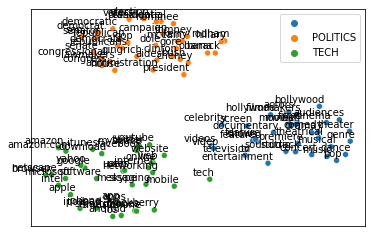

In [41]:
## word embedding
tot_words = [word for v in dic_clusters.values() for word in v]
X = nlp[tot_words]
        
## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(dtf) + len(v)
    dtf_group = pd.DataFrame(X[len(dtf):size], columns=["x","y"], 
                             index=v)
    dtf_group["cluster"] = k
    dtf = dtf.append(dtf_group)
        
## plot
fig, ax = plt.subplots()
sns.scatterplot(data=dtf, x="x", y="y", hue="cluster", ax=ax)
ax.legend().texts[0].set_text(None)
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], 
       yticks=[], yticklabels=[])
for i in range(len(dtf)):
    ax.annotate(dtf.index[i], 
               xy=(dtf["x"].iloc[i],dtf["y"].iloc[i]), 
               xytext=(5,2), textcoords='offset points', 
               ha='right', va='bottom')

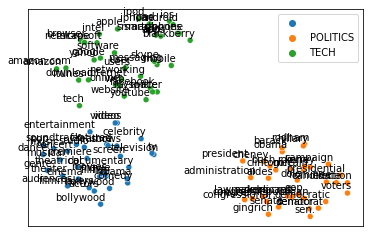

In [42]:
## word embedding
tot_words = [word for v in dic_clusters.values() for word in v]
X = nlp[tot_words]
        
## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(dtf) + len(v)
    dtf_group = pd.DataFrame(X[len(dtf):size], columns=["x","y"], 
                             index=v)
    dtf_group["cluster"] = k
    dtf = dtf.append(dtf_group)
        
## plot
fig, ax = plt.subplots()
sns.scatterplot(data=dtf, x="x", y="y", hue="cluster", ax=ax)
ax.legend().texts[0].set_text(None)
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], 
       yticks=[], yticklabels=[])
for i in range(len(dtf)):
    ax.annotate(dtf.index[i], 
               xy=(dtf["x"].iloc[i],dtf["y"].iloc[i]), 
               xytext=(5,2), textcoords='offset points', 
               ha='right', va='bottom')

In [31]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [32]:
txt = "river bank"
## tokenize
idx = tokenizer.encode(txt)
print("tokens:", tokenizer.convert_ids_to_tokens(idx))
print("ids   :", tokenizer.encode(txt))
## word embedding
idx = np.array(idx)[None,:]
embedding = nlp(idx)
print("shape:", embedding[0][0].shape)
## vector of the second input word
embedding[0][0][2]

tokens: ['[CLS]', 'river', 'bank', '[SEP]']
ids   : [101, 2314, 2924, 102]
shape: (4, 768)


<tf.Tensor: shape=(768,), dtype=float32, numpy=
array([-7.05822855e-02, -6.21527672e-01, -7.02520967e-01, -2.49587402e-01,
        5.77253878e-01,  4.81010586e-01,  2.44046316e-01,  5.12865603e-01,
       -3.52891207e-01, -8.16164255e-01,  3.99641395e-01,  1.81418449e-01,
        5.12113869e-01,  1.44479468e-01, -1.42232728e+00, -1.06337428e-01,
        1.06131630e-02, -4.34667945e-01,  1.13796735e+00,  7.06453770e-02,
        6.18477166e-01,  5.76443449e-02,  2.41198286e-01,  2.96010703e-01,
       -2.22420484e-01,  2.06983268e-01,  4.50172186e-01,  1.95634857e-01,
        7.22260028e-03,  7.06086338e-01,  6.82602167e-01, -3.35966051e-01,
        4.75641280e-01,  3.38769644e-01, -1.90573052e-01, -1.12146008e+00,
       -4.32032049e-02, -1.56870157e-01,  4.73267883e-02,  3.38264734e-01,
       -4.73710299e-01, -2.87371904e-01, -6.14665486e-02,  3.93016264e-02,
       -9.84504968e-02,  5.61645953e-03,  2.15944916e-01, -3.90442759e-02,
       -7.03861654e-01,  1.26935855e-01,  2.32842527

In [44]:
dtf["text_clean"].head()
## function to apply
def utils_bert_embedding(txt, tokenizer, nlp):
    idx = tokenizer.encode(txt)
    idx = np.array(idx)[None,:]  
    embedding = nlp(idx)
    X = np.array(embedding[0][0][1:-1])
    return X
## create list of news vector
lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0) 
                 for txt in dtf["text_clean"]]
## create the feature matrix (n news x 768)
X = np.array(lst_mean_vecs)

KeyError: ignored